In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
pd.options.display.float_format = "{:.4f}".format
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.lines import Line2D
plt.rcParams["figure.figsize"] = (16,10)
plt.style.use("~/.dracula.mplstyle")
import datetime as dt
import os, sys, time, asyncio
import quandl
import functools

# QUANDL Config
parent_path = os.path.abspath(os.path.join('..'))
if parent_path not in sys.path:
    sys.path.append(parent_path)
from common.config import QUANDL_API_KEY
# If you are not Philip, you don't have common.config unless you make your own.

quandl.ApiConfig.api_key = QUANDL_API_KEY # Replace with your API key if running.
# api = os.getenv("QUANDL_KEY")

## Define `GLOBAL CONST` Variables

---

These do not get changed throughout the notebook.

In [2]:
START_DATE = dt.date(year=2013, month=1, day=1)
END_DATE   = dt.date(year=2021, month=1, day=1)
DATERANGE  = {"gte": START_DATE.strftime("%Y-%m-%d"), 
              "lte": END_DATE.strftime("%Y-%m-%d")}
DATERANGE_PRICES  = {"gte": (START_DATE+pd.DateOffset(years=1)
                             ).strftime("%Y-%m-%d"),
                     "lte": END_DATE.strftime("%Y-%m-%d")}

DE_THRESH = 0.1 # Debt/Market Cap Threshold

DB_TED = "FRED/TEDRATE"
DB_T3M = "FRED/DTB3"

GC_DISCOUNT = 0.01

In [3]:
if "CACHED" in globals():
    print("Not re-defining.")
else:
    print("Defining quandl pull")
    CACHED = True
    @functools.lru_cache(maxsize=16)
    def quandl_get_cached(pull, start_date, end_date):
        ret = quandl.get(pull, start_date=start_date, end_date=end_date)
        return ret
    
    @functools.lru_cache(maxsize=16)
    def quandl_get_table_cached(db, assets, start_date, end_date):
        ret = quandl.get_table(db, ticker=list(assets),
                               date={"gte":START_DATE, "lte":END_DATE})
        return ret

Defining quandl pull


# 1 Introduction

Here you will consider a few financial accounting ratios, as an approxima- tion of “quantamental” models that typically take much more numerous and carefully defined financial accounting into consideration. You will then in- vestigate profit opportunity of a quantile-based long-short scheme.

# 2 Understand Your Data

Read all documentation webpages for Zacks Fundamentals B. You will see they supply 6 related tables, FC, FR, MT, MKTV, SHRC and HDM 1. The strategy coding for this assignment will be reasonably easy. The data assembly, deliberately, is the difficult part.
# 3 Define the Universe

Choose at least 200 tickers of US equities such that3 they satisfy the following:

## Use Quandl API to Pull Data

---

I chose to use the API instead of a table download to simulate building a fully systematic strategy. Assuming that Quandl updates the tables containing close prices and financials in a timely fashion, it is possible for this strategy to become fully systematic without a significant amount of effort.

In [4]:
ted_raw = quandl_get_cached(DB_TED, START_DATE-pd.DateOffset(months=3), END_DATE)
t3m_raw = quandl_get_cached(DB_T3M, START_DATE-pd.DateOffset(months=3), END_DATE)

rates = (ted_raw.merge(t3m_raw, on="Date").sum(axis=1) / 100).to_frame("libor")
rates["gc"] = rates["libor"] - GC_DISCOUNT # General Collateral Rate

In [5]:
zmt = quandl.get_table("ZACKS/MT", paginate=True)
active_tickers = zmt[zmt["active_ticker_flag"]=='Y']["m_ticker"].unique()

• debt/market cap ratio is greater than 0.1 somewhere in the period Jan 2014 through Jan 2021 (preferably more than fleetingly)

---

**Implementation logic:** minimum debt/market cap ratio > 0.1. Also created a filter function to return relevant summary statistics in case we desire to become more flexible with the criteria we use to select `debt_mkt_cap`. Perhaps we can use mean and standard deviation to identify which tickers have `debt_mkt_cap` that mostly satisfy the requirement. Allowing more flexibility in filtering expands the strategy's scope and allows for a larger universe of tickers.

In [6]:
def filter_debt_mkt_cap(df):
    """Get Summary statistics for debt/market cap for exclusion"""
    mu = df["tot_debt_tot_equity"].mean()
    sig = df["tot_debt_tot_equity"].std()
    mi = df["tot_debt_tot_equity"].min()
    ma = df["tot_debt_tot_equity"].max()
    st = df["per_end_date"].min()
    ed = df["per_end_date"].max()
    tick = df["ticker"].iloc[0]
    return pd.Series([tick, mu, sig, mi, ma, st, ed], index=["ticker", "mean", "std", "min", "max", "start", "end"])

filter_fr = {"columns":["m_ticker", "ticker", "per_type", "per_end_date", "tot_debt_tot_equity", 
                        "ret_invst",]}
zfr = quandl.get_table("ZACKS/FR",  per_end_date=DATERANGE, qopts=filter_fr, paginate=True)

debt_mkt_cap_df = zfr.dropna().groupby("m_ticker").apply(filter_debt_mkt_cap).reset_index()
allowed_debt_mkt_cap_tickers = debt_mkt_cap_df.loc[debt_mkt_cap_df["min"]>DE_THRESH,"m_ticker"].unique()

• not in the automotive, financial or insurance sector , over the entire period Jan 2014 through Jan 2021

---

**Implementation logic:** `zacks_sector_code` not either 5 (auto) or 13 (financial or insurance)

In [7]:
def filter_excluded_sectors(df):
    """Not in automotive, financial or insurance sector
    Auto=5; Finance, Insurance=13"""
    if   (df["zacks_sector_code"]==5).any():  return False
    elif (df["zacks_sector_code"]==13).any(): return False
    else: return True
    
filter_fc = {"columns":["m_ticker", "ticker", "per_type", "per_end_date", "zacks_sector_code", "filing_date", 
                        "net_lterm_debt", "tot_lterm_debt", "eps_diluted_net", "basic_net_eps"]}
zfc = quandl.get_table("ZACKS/FC",  per_end_date=DATERANGE, qopts=filter_fc, paginate=True)

sector_df = zfc.groupby("m_ticker").apply(filter_excluded_sectors).to_frame("allowed_sector").reset_index()
allowed_sector_tickers = sector_df.loc[sector_df["allowed_sector"],"m_ticker"].unique()

• end-of-day adjusted closing prices are available, over the entire period Jan 2014 through Jan 2021

---

**Implementation logic:** Define relevant tickers as those that satisfy the requirement for the previous two conditions. Pull relevant tickers from `QUOTEMEDIA/EOD` and count the number of datapoints. I assume `AAPL` trades all days, so therefore, any ticker with an equal number of trading days will have traded for the entire period. The availability of reliable pricing data is essential for the strategy to compute ratios and execute trades.

In [8]:
def filter_closes(df):
    """Start and end dates of Time Series = GLOBAL CONST dates, counts number of closes."""
    st = df["date"].min()
    ed = df["date"].max()
    ct = df["date"].count()
    return pd.Series([st,ed,ct], index=["start", "end", "count"])

pull = set(allowed_debt_mkt_cap_tickers).intersection(set(allowed_sector_tickers))
pull = zmt.set_index("m_ticker").loc[pull,"ticker"].reset_index()

# Slice the pull into many different chunks because Quandl has a limit for each pull :P
frac = int(len(pull)/10)
filter_eod = {"columns":["ticker", "date"]}

eod_raw = []
for i in range(9):
    ts = list(pull["ticker"])[i*frac:(i+1)*frac]
    df = quandl.get_table('QUOTEMEDIA/PRICES', ticker=ts, date=DATERANGE_PRICES, paginate=True)
    eod_raw.append(df)

ts = list(pull["ticker"])[9*frac:]
df = quandl.get_table('QUOTEMEDIA/PRICES', ticker=ts, date=DATERANGE_PRICES, paginate=True)
eod_raw.append(df)

eod_raw = pd.concat(eod_raw, axis=0).reset_index(drop=True)

traded_df = eod_raw.groupby("ticker").apply(filter_closes).reset_index()

# Use AAPL as ground truth for a stock trading all days within the time range
aapl_count = traded_df[traded_df["ticker"]=="AAPL"]["count"].values[0]
traded_tickers = traded_df.loc[traded_df["count"]==aapl_count, "ticker"].unique()

In [9]:
for t in ["ASH", "VTOL", "ISUN", "VIVO"]:
    #                     ^ ISUN's debt/market cap is too unstable
    print(f"{t}\t{t in traded_tickers}")

ASH	True
VTOL	True
ISUN	False
VIVO	True


• has feasible calculation of the ratios specified below , over the entire period Jan 2014 through Jan 2021, including for at least one PER END DATE no more than one year old. Debt ratio of zero is OK.

• debt to market cap

• return on investment

• price to earnings

---

**Implementation logic:** Simply attempt to calculate all ratios and discard tickers with missing data.

In [10]:
# Get full EOD Dataset for tickers that meet above criteria

frac = int(len(traded_tickers)/10)

eod_raw = []
for i in range(9):
    ts = list(traded_tickers)[i*frac:(i+1)*frac]
    df = quandl.get_table('QUOTEMEDIA/PRICES', ticker=ts, date=DATERANGE, paginate=True)
    eod_raw.append(df)

ts = list(traded_tickers)[9*frac:]
df = quandl.get_table('QUOTEMEDIA/PRICES', ticker=ts, date=DATERANGE, paginate=True)
eod_raw.append(df)

eod = pd.concat(eod_raw, axis=0).reset_index(drop=True)
eod.sort_values(["ticker", "date"], inplace=True)

In [11]:
# Sanity check
assert len(traded_tickers) == (eod[eod["date"]>"2014"].groupby("ticker").count()["date"]==aapl_count).sum()
print(f"Total tickers: {len(traded_tickers)}")

Total tickers: 1095


## Merge Logic

---

Combine all fundamental tables from Zacks together because they are of the same frequency and format. A consolidated fundamental table's join with EOD data will be more performant than multiple joins.

In [12]:
# Prepare tables for merging
sub_zfc = zfc.set_index("ticker").loc[traded_tickers,:].reset_index()
sub_zfr = zfr.set_index("ticker").loc[traded_tickers,:].reset_index()
filter_zsh = {"columns":["m_ticker", "ticker", "per_type", "per_end_date", "shares_out"]}
sub_zsh = quandl.get_table('ZACKS/SHRS', ticker=list(traded_tickers), qopts=filter_zsh,
                           per_end_date=DATERANGE, paginate=True)
filter_zmk = {"columns":["m_ticker", "ticker", "per_type", "per_end_date", "mkt_val"]}
sub_zmk = quandl.get_table('ZACKS/MKTV', ticker=list(traded_tickers), qopts=filter_zmk,
                           per_end_date=DATERANGE, paginate=True)

## Consolidation

---

Combine all fundamental tables into a table called `zacks`. In addition to making merges easier, we may now use this table for relevant financial ratios for other studies in the future.

In [13]:
# Merges done here using inner join
zacks = sub_zfc[sub_zfc["per_type"]=='Q']
zacks = zacks.merge(sub_zfr[sub_zfr["per_type"]=='Q'], on=["per_end_date", "m_ticker"], suffixes=['', '_delete0'])
zacks = zacks.merge(sub_zsh[sub_zsh["per_type"]=='Q'], on=["per_end_date", "m_ticker"], suffixes=['', '_delete1'])
zacks = zacks.merge(sub_zmk[sub_zmk["per_type"]=='Q'], on=["per_end_date", "m_ticker"], suffixes=['', '_delete2'])
zacks = zacks[[z for z in zacks.columns if "_delete" not in z]]
zacks.sort_values(["ticker", "per_end_date"], inplace=True)

## Eliminate Failed Merges

---

By discarding tickers with unacceptably many NaN values. Prevent Quandl Database issues from hindering the proper analysis of ratios. Trading on poor quality data may cause diminished returns due to the absence of a significant signal.

NaN values indicate both unreliability of data and unrelability of signal. Assessing a strategy's performance on a dataset with missing data may lead to false conclusions about the strategy's performance as we cannot understand whether the NaN's improve or diminish performance.

In [14]:
def count_nas(df):
    return df.isna().sum(axis=0)

zacks_nas = zacks.groupby("m_ticker").apply(count_nas)
no_filing_date = zacks_nas[zacks_nas["filing_date"]>0].index

zacks_count = zacks.groupby("m_ticker").count()
quarters = 28
not_enough_quarters = zacks_count[zacks_count["ticker"]<quarters].index

thresh = 8
missing_debt = zacks_nas[(zacks_nas["net_lterm_debt"]>thresh) & (zacks_nas["tot_lterm_debt"]>thresh)].index

missing_de = zacks_nas[(zacks_nas["tot_debt_tot_equity"]>thresh)].index

missing_roi = zacks_nas[(zacks_nas["ret_invst"]>thresh)].index

to_discard = set(no_filing_date).union(set(not_enough_quarters), set(missing_debt), 
                                       set(missing_de), set(missing_roi))
zacks = zacks.set_index("m_ticker").loc[set(zacks["m_ticker"]) - to_discard,:].reset_index()

At times, `per_end_date` is not a trading day. Therefore, we must fill in data from previous trading days to find a closing price for all `per_end_date`s.

In [15]:
for i in range(5):
    temp = eod[["ticker", "date", "adj_close"]].copy(deep=True)
    temp["date"] = temp["date"]+pd.DateOffset(days=i)
    zacks = zacks.merge(temp, 
                        left_on=["ticker", "per_end_date"], 
                        right_on=["ticker", "date"], how="left", suffixes=['', f"_{i}"])

for i in range(1,5):
    zacks["adj_close"] = zacks["adj_close"].combine_first(zacks[f"adj_close_{i}"])
    
zacks.drop("date", axis=1, inplace=True)
zacks.drop(zacks.columns[15:], axis=1, inplace=True)
zacks.rename(columns={"adj_close": "end_adj_close"}, inplace=True)

Consolidate `debt` and `eps` figures for ease of use in future calculations. Since the same logic is used for missing values in this column, we will save the data so we do not need to recalculate it for other ratios.

In [16]:
def create_debt(df):
    if df["net_lterm_debt"].isna().any():
        return df[["per_end_date", "tot_lterm_debt"]]
    else:
        return df[["per_end_date", "net_lterm_debt"]]
    
def create_eps(df):
    if df["eps_diluted_net"].isna().any():
        return df[["per_end_date", "basic_net_eps"]]
    else:
        return df[["per_end_date", "eps_diluted_net"]]

debt = zacks.groupby("m_ticker").apply(create_debt).reset_index()
eps = zacks.groupby("m_ticker").apply(create_eps).reset_index()
zacks["debt"] = zacks["net_lterm_debt"].combine_first(zacks["tot_lterm_debt"])
zacks["eps"] = eps["eps_diluted_net"].fillna(0) + eps["basic_net_eps"].fillna(0)
zacks["ret"] = zacks["ret_invst"] * (zacks["debt"] + zacks["mkt_val"])
zacks.fillna(method="ffill", inplace=True)

## Final Raw Data Build

---

Merge fundamentals with EOD prices. If this is done properly, calculating signal financial ratios will yield results consistent with the provided calculations on the homework instructions. If the ratios are incorrect, it is most likely that we made a mistake with data cleaning above or in the following merge cell.

In [17]:
eodz = eod.set_index("ticker").loc[set(zacks["ticker"]),:].reset_index()
eodz = eodz.merge(zacks, left_on=["ticker", "date"], right_on=["ticker", "filing_date"], how="left")
eodz[eodz.columns[14:]] = eodz[eodz.columns[14:]].shift(1)
to_fill = eodz.columns[14:]

eodz[to_fill] = eodz.groupby("ticker").fillna(method="ffill")[to_fill]
eodz = eodz.reset_index(drop=True)

# 4 Select Financial Ratios

For this assignment, we will work with the following ratios:

• debt to market cap

• return on investment

• price to earnings

Note that these data items are reported (at best) quarterly. Use annual numbers only when quarterly ones do not exist. As the equity price changes day-to-day, each ratio changes accordingly, so ultimately the time series you have will be on daily data. Recall that we did not know any of these numbers until the FC/FILING DATE.

## Interpreting Financial Ratios used as Trading Signals

---

`debt_mkt_cap` reveals information about how much a company is encumbered by financing obligations. A high `debt_mkt_cap` ratio signals the expansion of a business and its reliance on external financing. Low `debt_mkt_cap` ratios may indicate that a company's expansion is slowing. Consider two companies with identical income statements up to EBITDA: the one with lower `debt_mkt_cap` will have lower interest expenses and thus higher profitability. However, we disregard this observation to interpret higher `debt_mkt_cap` favorably.

`roi` reveals a company's ability to earn based on the size of its balance sheet. A high `roi` is interpreted favorably as a large yield compared with teh combination of the firm's debt and equity. A low `roi` identifies a poor investment.

`earnings_yield` addresses a company's profit in proportion to its valuation. A higher `earnings_yield` means that the company is generating more profit relative to its share price, therefore indicating that the stock is at a fair price poised for growth. A lower `earnings_yield` indicates lower profitability or even per-share losses.

`price_earnings` is not used in the below analysis. The substitution of `earnings_yield` for `price_earnings` was approved by Professor Boonstra on Edstem. `price_earnings` is a bad indicator because it exhibits asymptotic behavior as earnings approaches 0. `price_earnings` is confusing to interpret since negative values of larger magnitude indicate superior performance whereas positive values of larger magnitude indicate that the asset is overpriced.

In [18]:
eodz["debt_mkt_cap"] = eodz["tot_debt_tot_equity"] * eodz["end_adj_close"] / eodz["adj_close"]
eodz["roi"] = eodz["ret"] / (eodz["debt"] + eodz["mkt_val"] * eodz["adj_close"] / eodz["end_adj_close"])
eodz["earnings_yield"] = eodz["eps"] / eodz["adj_close"]
eodz["price_earnings"] = eodz["adj_close"] / eodz["eps"]
eodz = eodz[eodz["date"]>"2013-06-01"]

In [19]:
mask_na = (eodz["earnings_yield"].isna()) | (eodz["debt_mkt_cap"].isna()) | (eodz["roi"].isna())
has_nas = eodz.loc[mask_na, "ticker"].unique()
c = eodz.groupby("ticker").count()
wrong_days = c[c["date"]!=c.loc["AAPL", "date"]].index

exclude = np.concatenate([has_nas, wrong_days])
mask_excl = eodz["ticker"]=="NONEXISTENT"
for e in exclude:
    mask_excl |= eodz["ticker"]==e
eodz = eodz[~mask_excl].sort_values(["date", "ticker"]).reset_index(drop=True)
eodz.to_pickle("eodz.pkl")

## Checkpoint: Save Data to Avoid Quandl Calls

---

Use a .pkl file to store the newly-constructed `eodz` DataFrame. The rest of the notebook only depends on running through `Cell [4]` and loading `eodz.pkl`.

In [20]:
try:
    eodz = pd.read_pickle("eodz.pkl")
except FileNotFoundError:
    print("Run it back, turbo (from the top)")

## Create Combination of Debt/Market Cap and Earnings Yield

---

Because `roi` and `earnings_yield` have multicollinearlty, I chose to create a combination ratio using `debt_mkt_cap` and `earnings_yield` by normalizing the values and adding the Z scores. This scales the two variables to the same size and allows for a fair combination without one overpowering the other.

## Key Insight

---

**A high `debt_mkt_cap` coupled with a high `earnings_yield` strongly indicates that the company is growing!** The company is successfully using its leverage to drive stellar earnings.

In [21]:
mu_de  = eodz["debt_mkt_cap"].mean()
sig_de = eodz["debt_mkt_cap"].std()
mu_ey  = eodz["earnings_yield"].mean()
sig_ey = eodz["earnings_yield"].std()

eodz["de_ey"] = (eodz["debt_mkt_cap"] - mu_de) / sig_de + (eodz["earnings_yield"] - mu_ey) / sig_ey

## Check to verify numbers against Table 6.0.2

---

`debt_mkt_cap`, `roi`, and `price_earnings` match perfectly. Not a single calculation is wrong compared with the homework instructions!

In [22]:
check = ["2019-10-25", "2019-10-28", "2019-12-31", "2020-01-02", "2020-02-19", 
         "2020-02-20", "2020-03-31", "2020-04-01", "2020-05-01", "2020-05-04", 
         "2020-06-30", "2020-07-01", "2020-07-31", "2020-08-03", "2020-09-30", 
         "2020-10-01", "2020-10-28", "2020-10-29", "2020-12-31"]

lly = []
temp = eodz[eodz["ticker"]=="LLY"].set_index("date")
for c in check:
    lly.append(temp.loc[c,:])
pd.concat(lly, axis=1).T[["debt_mkt_cap", "roi", "price_earnings"]]

,debt_mkt_cap,roi,price_earnings
2019-10-25,5.5545,8.0487,73.4678
2019-10-28,4.3524,7.2497,79.1767
2019-12-31,3.7202,6.2277,92.6316
2020-01-02,3.6982,6.1920,93.1813
2020-02-19,3.4538,5.7940,99.7747
2020-02-20,5.2252,8.3567,77.8683
2020-03-31,5.3488,8.5490,76.0697
2020-04-01,5.4389,8.6892,74.8084
2020-05-01,4.8297,7.7395,84.2459
2020-05-04,4.8773,7.6712,92.9847


# 5 Analysis

Study performance of weekly or monthly quantile trading strategies using each of these single ratios as well as your choice of least one nontrivial combination of them.

Set initial capital to be 10 times the gross notional of your first month’s set of positions. You may assume zero trading costs, that trading fractional shares and arbitrary positions sizes are possible, that all securities are easy to borrow with a repo rate equal to your funding rate minus 100bp, and that the portfolio capital is equal to the initial capital, adjusted for all realized and unrealized PL to date. Choose either a constant funding rate, or rolling 3-month LIBOR.
Analyze performance of a top-and-bottom decile trading strategy. Now rank based on changes in your ratios rather than the ratios themselves. Play with the effects of sizing positions by rank.

## Perform Final Checks

---

To ensure that the data we are feeding the algoroithm is valid. Only using valid data will allow us to make conclusions about the performance of our strategy.

In [23]:
def ticker_nas(df):
    l = len(df)
    no_de = df["debt_mkt_cap"].isna().sum()
    no_ro = df["roi"].isna().sum()
    no_ey = df["price_earnings"].isna().sum()
    no_de_ey = df["de_ey"].isna().sum()
    return pd.Series([l, no_de, no_ro, no_ey, no_de_ey], index=["length", "no_de", "no_ro", "no_ey", "no_de_ey"])

na_eod = eodz.groupby("ticker").apply(ticker_nas)#.plot.hist()
na_eod.isna().any()
# No NaN values anywhere essentally

length      False
no_de       False
no_ro       False
no_ey       False
no_de_ey    False
dtype: bool

## Apply EWMA to Daily Signals

---

EWMA improves the stability of each signal. Therefore positions are more likely to be held for longer because daily fluctiations are "dampemed" by EWMA. This method prevents excessive turnover at the cost of responding to changing information more slowly.

In [24]:
cols = ["ticker", "debt_mkt_cap", "roi", "earnings_yield", "de_ey"]

center_of_mass = 5
ewm_ind = eodz[cols].groupby("ticker").ewm(com=center_of_mass).mean()

signal_cols = ["sig_de", "sig_roi", "sig_ey", "sig_de_ey"]
eodz[signal_cols] = ewm_ind.reset_index(level=0, drop=True).sort_index()

## Obtain the Change of Ratio Signals

---

Use 5 day change in order to accomodate for weekly trading. I prefer using log returns because they compound using addition, and are thefore simpler to aggregate.

In [25]:
chgs = eodz[["ticker"] + signal_cols].groupby("ticker").diff(5)

chg_cols = ["chg_de", "chg_roi", "chg_ey", "chg_de_ey"]
eodz[chg_cols] = chgs.reset_index(level=0, drop=True).sort_index()

## Use Rank Instead of Quantile

---

Allows for more flexible logic, especially with variable position sizing. Rank increases the resolution of information contained in the data.

In [26]:
def rank_assignment(df, field):
    """Assigns quantiles to each field
    Fills NaN values as 5 to not interfere with trading logic."""
    return df[field].rank().astype(int)

eodz = eodz[eodz["date"]>"2014"]

fields = ["sig_de", "sig_roi", "sig_ey", "sig_de_ey", 
          "chg_de", "chg_roi", "chg_ey", "chg_de_ey"]
for f in fields:
    eodz[f"r_{f}"] = eodz.groupby("date").apply(rank_assignment, field=f).reset_index(level=0, drop=True)

## Construct `trading_df`

---

`trading_df` contains the necessary columns to run the strategy. This thins out `eodz` and keeps only the relevant columns for running the strategy.

In [27]:
eodz_cols = ["date", "ticker", "adj_close", 
             "r_sig_de", "r_sig_roi", "r_sig_ey", "r_sig_de_ey",
             "r_chg_de", "r_chg_roi", "r_chg_ey", "r_chg_de_ey"]

trading_df = eodz[eodz_cols].copy(deep=True)
gc_rate = (rates["gc"] / 52).rolling(30).mean().to_frame().reset_index().rename(columns={"Date": "date"})
trading_df = trading_df.merge(gc_rate, on="date")
trading_df.set_index("date", inplace=True)

trading_df = trading_df.groupby("ticker").resample("W-Fri", label="right").last()
trading_df = trading_df.reset_index(level=0, drop=True)
trading_df.sort_values(["date","ticker"], inplace=True)
trading_df.reset_index(inplace=True)

In [28]:
include_inverses = False

if include_inverses:
    cols = ["r_sig_de", "r_sig_roi", "r_sig_ey", "r_sig_de_ey"]
    invs = ["inv_de", "inv_roi", "inv_ey", "inv_de_ey"]

    top_rank = trading_df["r_sig_de"].max()

    trading_df[invs] = top_rank - trading_df[cols]
    
trading_df

,date,ticker,adj_close,r_sig_de,r_sig_roi,r_sig_ey,r_sig_de_ey,r_chg_de,r_chg_roi,r_chg_ey,r_chg_de_ey,gc
0,2014-01-03,AAP,109.1485,113,571,325,137,394,120,275,366,-0.0001
1,2014-01-03,AAPL,17.1092,3,603,430,67,560,623,591,566,-0.0001
2,2014-01-03,AAWW,40.5300,564,188,555,573,43,268,40,41,-0.0001
3,2014-01-03,ABG,53.0300,615,433,341,609,236,407,418,286,-0.0001
4,2014-01-03,ABT,32.9285,103,390,477,165,412,273,239,371,-0.0001
...,...,...,...,...,...,...,...,...,...,...,...,...
240457,2021-01-01,YORW,45.8298,310,397,285,320,450,391,388,436,-0.0001
240458,2021-01-01,ZBH,153.1048,252,328,282,266,202,214,237,201,-0.0001
240459,2021-01-01,ZD,97.6900,368,441,438,400,303,259,271,288,-0.0001
240460,2021-01-01,ZEUS,13.2848,163,140,120,109,603,288,88,574,-0.0001


## `TradingEngine` and `QuantileEngine` Objects

---

Becuse different variations on the trading strategies will require different execution logic, I created a base class `TradingEngine` that does much of the data formatting and loading. `QuantileEngine(TradingEngine)` inherits from the base class but 

This design enables the rapid developement of variants on the execution logic.

In [29]:
class TradingEngine:
    """TradingEngine Template for inheritance.
    This object does not work standalone and requires
    child classes to build incomplete functions
    """
    
    def __init__(self, data, starting_cash=1e6):
        """Constructor only takes in a DataFrame that is contains the following:
        ["date", "ticker", "adj_close", "gc", <signal1>, ... ]
        data must be sorted by ticker, otherwise indexing across differnt dates fails."""
        self.data = data
        self.debug = False # True: prints debug statements at crucial method calls
        self.performance = self.initialize_ts()
        self.signals = self.initialize_signals()
        self.starting_cash = starting_cash
        
    def initialize_book(self):
        """Creates a book used to store long and short positions.
        Index is tickers (for ease of slicing). Also stores:
        ["adj_close", "size", "cost"] to determine P/L when closing positions
        """
        first = self.data["date"]==self.data["date"].min()
        book = self.data.loc[first, ["ticker", "adj_close"]].set_index("ticker")
        book["adj_close"] = 0; book["size"] = 0; book["cost"] = 0
        return book
    
    def initialize_ts(self):
        """Creates empty DataFrame to store time series"""
        return pd.DataFrame(index=self.data["date"].unique())
    
    def initialize_signals(self):
        """All columns inside self.data are signals except those in cols"""
        if "all" in self.data.columns:
            raise ValueError("Please name your signal something  other than 'all'")
        cols = ["date", "ticker", "adj_close", "gc"]
        return [c for c in self.data.columns if c not in cols]
            
    def run_strategy(self, signal):
        """Creates strategy and runs it for the given signal.
        self.run_strategy(signal) sets up the strategy and enables looping.
        Other methods are required to act on the strategy.
        RELIES ON THE DECLARATION OF CHILD CLASS METHODS:
        self.initialize_strategy(signal)
        self.run_rebalance(d, trad)"""
        if signal=="all":
            # "all" is not a signal. Therefore, passing it runs
            # all contained strategies recursively.
            for sig in self.signals:
                self.run_strategy(sig)
            return None # stop the run here.
        
        # Create a fresh set of books for the strategy
        self.long_book = self.initialize_book()
        self.short_book = self.initialize_book()
        # Reset self.cash in case previous strategies altered it
        self.cash = self.starting_cash
        self.strat = self.initialize_strategy(signal)
        
        # d is date in groupby; day is a DataFrame containing signal and price information
        for d, day in self.strat.groupby("date"):
            # Populate books with the most recent close prices
            self.update_books(d, day)
            trad = day[day["pos_chg"]!=0] # pass only the relevant trades
            # Rebalance positions and record the mark to market value
            m2m = self.run_rebalance(d, trad)
            self.performance.loc[d, signal] = m2m
    
    def initialize_strategy(self, signal): 
        # must be overriden in child class
        raise NotImplementedError("initialize_strategy() must be overrided")
    
    def run_rebalance(self, d, trad):
        # must be overriden in child class
        raise NotImplementedError("run_rebalance() must be overrided")
    
    def update_books(self, d, day):
        """Populates books with the most updated adj_close prices."""
        if self.debug: print(f"update_books({d})")
        self.long_book["adj_close"] = day["adj_close"].values
        self.short_book["adj_close"] = day["adj_close"].values
    
    def value_long(self, tickers=[]):
        """Returns the value of long positions on tickers in the book
        close * holding size = value"""
        if len(tickers)==0:
            tickers = self.long_book.index
        closes = self.long_book.loc[tickers,"adj_close"].values
        size = self.long_book.loc[tickers,"size"].values
        return closes.dot(size)
    
    def value_short(self, tickers=[]):
        """Returns the value of short positions on tickers in the book
        (cost + (cost-close)) * holding size = value
                ^ gain/loss from short"""
        if len(tickers)==0:
            tickers = self.short_book.index
        cost = self.short_book.loc[tickers,"cost"].values
        cover = self.short_book.loc[tickers,"adj_close"].values
        size = self.short_book.loc[tickers,"size"].values
        return (2*cost-cover).dot(size)
        
    def sell_to_close(self, tickers):
        """Sells these tickers, returns the cash, and zeros the long book"""
        if len(tickers)==0: return None
        proceeds = self.value_long(tickers)
        if self.debug: print(f"sell_to_close() +{proceeds:.0f}")
        self.cash += proceeds
        self.long_book.loc[tickers,"cost"] = 0
        self.long_book.loc[tickers,"size"] = 0
    
    def buy_to_close(self, tickers):
        """Buys these tickers, returns the cash, and zeros the short book"""
        if len(tickers)==0: return None
        proceeds = self.value_short(tickers)
        if self.debug: print(f"buy_to_close() +{proceeds:.0f}")
        self.cash += proceeds
        self.short_book.loc[tickers,"cost"] = 0
        self.short_book.loc[tickers,"size"] = 0
    
    def sell_to_open(self, tickers, dollars):
        """Initiates short positions, subtracts cash, adds to short book"""
        if len(tickers)==0: return None
        self.short_book.loc[tickers,"cost"] = self.short_book.loc[tickers,"adj_close"]
        self.short_book.loc[tickers,"size"] = dollars / self.short_book.loc[tickers,"cost"]
        costs = self.short_book.loc[tickers,"cost"].values.dot(
            self.short_book.loc[tickers,"size"].values)
        if self.debug: print(f"sell_to_open() -{costs:.0f}")
        self.cash -= costs
    
    def buy_to_open(self, tickers, dollars):
        """Initiates long positions, subtracts cash, adds to long book"""
        if len(tickers)==0: return None
        self.long_book.loc[tickers,"cost"] = self.long_book.loc[tickers,"adj_close"]
        self.long_book.loc[tickers,"size"] = dollars / self.long_book.loc[tickers,"cost"]
        costs = self.long_book.loc[tickers,"cost"].values.dot(
            self.long_book.loc[tickers,"size"].values)
        if self.debug: print(f"buy_to_open() -{costs:.0f}")
        self.cash -= costs


class QuantileEngine(TradingEngine):
    """Overrides TradingEngine functions to complete the strategy"""
    
    def initialize_strategy(self, signal):
        """Creates the necessary columns for trading based on the top and bottom quantiles."""
        def pos_chg(df):
            """Helper function to get change in position
            This is used to conduct trades!"""
            return  df["position"] - df["position"].shift(1).fillna(0)
        # Build trading data for specific signal
        cols = ["date", "ticker", "adj_close", "gc", signal]
        strat = self.data[cols].copy(deep=True).rename(columns={signal: "signal"})
        
        # Build thresholds for determining what lies in the quantiles
        n = strat["signal"].max() + 1
        buy_thresh, sell_thresh = n*0.9, n*0.1
        # Holds "position" if within threshold; needed to create "pos_chg" (trading actions)
        strat["position"] = ((strat["signal"] > buy_thresh).astype(int) 
                             - (strat["signal"] < sell_thresh).astype(int))
        strat["pos_chg"] = strat[["ticker", "position"]].groupby("ticker") \
                .apply(pos_chg).reset_index(level=0, drop=True).sort_index().astype(int).values
        return strat
    
    def run_rebalance(self, d, trad):
        """Closes positions, allocates cash on hand, opens new positions"""
        if self.debug: print(f"run_strategy({d})")
        # Use masks to deal with the different trading actions required
        mask_sell_to_close = (trad["position"]==0 ).values & (trad["pos_chg"]==-1).values
        mask_buy_to_close  = (trad["position"]==0 ).values & (trad["pos_chg"]==1 ).values
        mask_sell_to_open  = (trad["position"]==-1).values & (trad["pos_chg"]==-1).values
        mask_buy_to_open   = (trad["position"]==1 ).values & (trad["pos_chg"]==1 ).values
        # Sometimes, the position must reverse (think terrible earnings report)
        # We handle this by first closing the intial position, then 
        mask_sell_to_rev   = (trad["position"]==-1).values & (trad["pos_chg"]==-2).values
        mask_buy_to_rev    = (trad["position"]==1 ).values & (trad["pos_chg"]==2 ).values
        
        # Count the number of actions taken based on each category
        closes = mask_sell_to_close.sum() + mask_buy_to_close.sum()
        opens = mask_sell_to_open.sum() + mask_buy_to_open.sum()
        reverses = mask_sell_to_rev.sum() + mask_buy_to_rev.sum()
        n_trades = len(trad)
        actions = closes+opens+reverses
        if actions!=n_trades:
            # This means something is very wrong!
            print(f"run_strategy actions={actions}, trad={n_trades}")
            display(trad)
        
        # Debugging Purposes
        long_val_b  = self.value_long()
        short_val_b = self.value_short()
        if self.debug: print(f"Mark to market before long={long_val_b:.0f}",
                             f"short={short_val_b:.0f}")
        
        # Close positions to get cash on hand to trade with
        self.sell_to_close(trad.loc[mask_sell_to_close | mask_sell_to_rev, "ticker"])
        self.buy_to_close( trad.loc[mask_buy_to_close  | mask_buy_to_rev,  "ticker"])
        
        # If our number of trades is not 0, we trade :D
        if (opens+reverses):
            dollars = self.cash / (opens+reverses)
            # Now that we have closed and gotten cash, we open new positions
            self.sell_to_open( trad.loc[mask_sell_to_open | mask_sell_to_rev, "ticker"], dollars)
            self.buy_to_open(  trad.loc[mask_buy_to_open  | mask_buy_to_rev,  "ticker"], dollars)

        long_val_a  = self.value_long()
        short_val_a = self.value_short()
        if self.debug: print(f"Mark to market after long={long_val_a:.0f}",
                             f"short={short_val_a:.0f}")
        return long_val_a + short_val_a
        # Implement m2m and interest accumulation here by replacing the return



qe = QuantileEngine(trading_df)
# qe.debug=True
qe.run_strategy("all")
qe.performance

,r_sig_de,r_sig_roi,r_sig_ey,r_sig_de_ey,r_chg_de,r_chg_roi,r_chg_ey,r_chg_de_ey
2014-01-03,1000000.0000,1000000.0000,1000000.0000,1000000.0000,1000000.0000,1000000.0000,1000000.0000,1000000.0000
2014-01-10,994157.6046,1001719.5449,1001578.4327,998221.1556,1003736.1213,999124.7001,999043.2208,1005125.3023
2014-01-17,988830.1457,989058.7411,995597.0200,985757.1995,1000903.4799,996270.8750,1002466.3039,1004036.8681
2014-01-24,985395.6873,986202.5806,995278.9004,981762.1205,1000600.1154,1001745.8576,1003895.1131,1008145.7175
2014-01-31,993387.5067,981899.5358,993925.6850,987051.1769,994660.4173,1007300.1742,1003814.4348,1007768.2385
...,...,...,...,...,...,...,...,...
2020-12-04,1156032.0455,1096052.2340,944366.1827,1143750.4593,1111846.9030,1198086.2282,1340863.9357,1588544.3729
2020-12-11,1146135.7649,1087474.5154,931514.5308,1127376.6988,1080412.4311,1219140.0712,1381979.7674,1626161.5259
2020-12-18,1156275.0748,1110351.3455,957055.6128,1163777.2349,1108555.7790,1198104.8269,1344551.4426,1585797.7499
2020-12-25,1124361.0391,1098563.2352,947352.0462,1145026.5111,1110656.9687,1206953.1509,1356780.2772,1599844.2921


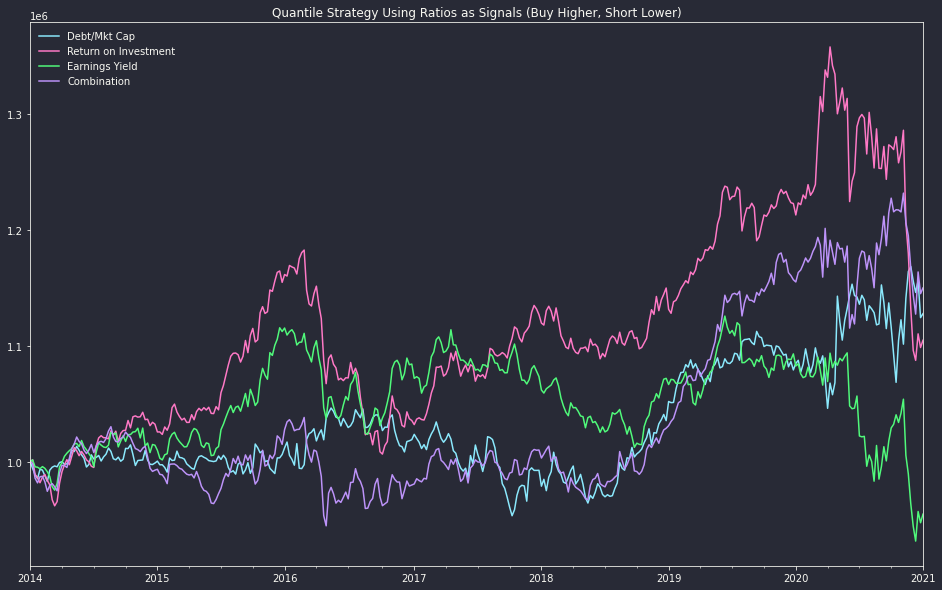

In [30]:
qe.performance.iloc[:,:4].plot()
plt.legend(["Debt/Mkt Cap ", "Return on Investment", "Earnings Yield", "Combination"])
plt.title("Quantile Strategy Using Ratios as Signals (Buy Higher, Short Lower)")
plt.show()

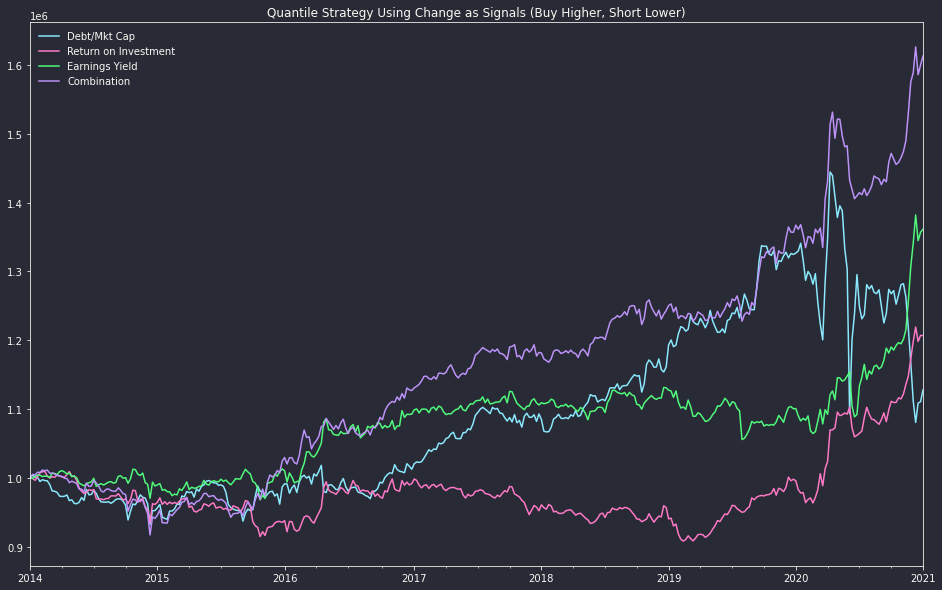

In [31]:
qe.performance.iloc[:,4:].plot()
plt.legend(["Debt/Mkt Cap ", "Return on Investment", "Earnings Yield", "Combination"])
plt.title("Quantile Strategy Using Change as Signals (Buy Higher, Short Lower)")
plt.show()

In [ ]:
class DynamicSizingEngine(TradingEngine):
    """Overrides TradingEngine functions to complete the strategy"""
    
    def initialize_strategy(self, signal):
        """Creates the necessary columns for trading based on higher and lower quantiles."""
        def pos_chg(df):
            """Helper function to get change in position
            This is used to conduct trades!"""
            return  df["position"] - df["position"].shift(1).fillna(0)
        # Build trading data for specific signal
        cols = ["date", "ticker", "adj_close", "gc", signal]
        strat = self.data[cols].copy(deep=True).rename(columns={signal: "signal"})
        
        # Build thresholds for determining what lies in the quantiles
        n = strat["signal"].max() + 1
        buy_thresh1, sell_thresh1 = n*0.9, n*0.1
        buy_thresh2, sell_thresh2 = n*0.8, n*0.2
        # Holds "position" if within threshold; needed to create "pos_chg" (trading actions)
        strat["position1"] = ((strat["signal"] > buy_thresh1).astype(int) 
                             - (strat["signal"] < sell_thresh1).astype(int))
        strat["pos_chg1"] = strat[["ticker", "position"]].groupby("ticker") \
                .apply(pos_chg).reset_index(level=0, drop=True).sort_index().astype(int).values
        strat["position2"] = ((strat["signal"] > buy_thresh2).astype(int) 
                             - (strat["signal"] < sell_thresh2).astype(int)) - strat["position1"]
        strat["pos_chg2"] = strat[["ticker", "position"]].groupby("ticker") \
                .apply(pos_chg).reset_index(level=0, drop=True).sort_index().astype(int).values
        return strat
    
    def run_rebalance(self, d, trad):
        """Closes positions, allocates cash on hand, opens new positions"""
        if self.debug: print(f"run_strategy({d})")
        # Use masks to deal with the different trading actions required
        # Pos 1 ----------------------
        mask_sell_to_close1 = (trad["position1"]==0 ).values & (trad["pos_chg1"]==-1).values
        mask_buy_to_close1  = (trad["position1"]==0 ).values & (trad["pos_chg1"]==1 ).values
        mask_sell_to_open1  = (trad["position1"]==-1).values & (trad["pos_chg1"]==-1).values
        mask_buy_to_open1   = (trad["position1"]==1 ).values & (trad["pos_chg1"]==1 ).values
        # Sometimes, the position must reverse (think terrible earnings report)
        # We handle this by first closing the intial position, then 
        mask_sell_to_rev1   = (trad["position1"]==-1).values & (trad["pos_chg1"]==-2).values
        mask_buy_to_rev1    = (trad["position1"]==1 ).values & (trad["pos_chg1"]==2 ).values
        
        # Pos 2 ----------------------
        mask_sell_to_close2 = (trad["position2"]==0 ).values & (trad["pos_chg2"]==-1).values
        mask_buy_to_close2  = (trad["position2"]==0 ).values & (trad["pos_chg2"]==1 ).values
        mask_sell_to_open2  = (trad["position2"]==-1).values & (trad["pos_chg2"]==-1).values
        mask_buy_to_open2   = (trad["position2"]==1 ).values & (trad["pos_chg2"]==1 ).values
        # Sometimes, the position must reverse (think terrible earnings report)
        # We handle this by first closing the intial position, then 
        mask_sell_to_rev2   = (trad["position2"]==-1).values & (trad["pos_chg2"]==-2).values
        mask_buy_to_rev2    = (trad["position2"]==1 ).values & (trad["pos_chg2"]==2 ).values
        
        # Count the number of actions taken based on each category
        closes = (mask_sell_to_close1.sum() + mask_buy_to_close1.sum() 
                  + mask_sell_to_close2.sum() + mask_buy_to_close2.sum())
        opens = (mask_sell_to_open1.sum() + mask_buy_to_open1.sum() 
                 + mask_sell_to_open2.sum() + mask_buy_to_open2.sum())
        reverses = (mask_sell_to_rev1.sum() + mask_buy_to_rev1.sum() 
                    + mask_sell_to_rev2.sum() + mask_buy_to_rev2.sum())
        n_trades = len(trad)
        actions = closes+opens+reverses
        if actions!=n_trades:
            # This means something is very wrong!
            print(f"run_strategy actions={actions}, trad={n_trades}")
            display(trad)
        
        # Debugging Purposes
        long_val_b  = self.value_long()
        short_val_b = self.value_short()
        if self.debug: print(f"Mark to market before long={long_val_b:.0f}",
                             f"short={short_val_b:.0f}")
        
        # Close positions to get cash on hand to trade with
        self.sell_to_close(trad.loc[mask_sell_to_close | mask_sell_to_rev, "ticker"])
        self.buy_to_close( trad.loc[mask_buy_to_close  | mask_buy_to_rev,  "ticker"])
        
        # If our number of trades is not 0, we trade :D
        if (opens+reverses):
            dollars = self.cash / (opens+reverses)
            # Now that we have closed and gotten cash, we open new positions
            self.sell_to_open( trad.loc[mask_sell_to_open | mask_sell_to_rev, "ticker"], dollars)
            self.buy_to_open(  trad.loc[mask_buy_to_open  | mask_buy_to_rev,  "ticker"], dollars)

        long_val_a  = self.value_long()
        short_val_a = self.value_short()
        if self.debug: print(f"Mark to market after long={long_val_a:.0f}",
                             f"short={short_val_a:.0f}")